## Базовый ML-пайплайн на примере Kaggle Titanic

In [19]:
import pandas as pd

Читаем данные

In [24]:
train = pd.read_csv('/content/train.csv')
test  = pd.read_csv('/content/test.csv')

In [25]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Dictionary (описание признаков Titanic)

| Переменная | Определение | Ключ / Значения |
|-------------|--------------|------------------|
| **Survived** | Факт выживания пассажира | 0 — не выжил, 1 — выжил |
| **Pclass** | Класс билета (социально-экономический статус) | 1 — 1-й класс, 2 — 2-й, 3 — 3-й |
| **Sex** | Пол пассажира | male / female |
| **Age** | Возраст (в годах) | числовое значение |
| **SibSp** | Количество братьев / сестёр / супругов на борту | целое число |
| **Parch** | Количество родителей / детей на борту | целое число |
| **Ticket** | Номер билета | текстовая строка |
| **Fare** | Стоимость билета | числовое значение |
| **Cabin** | Номер каюты | текстовая строка (много пропусков) |
| **Embarked** | Порт посадки | C — Шербур (Cherbourg), Q — Куинстаун (Queenstown), S — Саутгемптон (Southampton) |


In [7]:
print(train.shape)      # размерность (строки, столбцы)
print()
print(train.dtypes)     # типы столбцов
print()
train.sample(5, random_state=42) # случайная выборка

(418, 11)

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
321,1213,3,"Krekorian, Mr. Neshan",male,25.0,0,0,2654,7.2292,F E57,C
324,1216,1,"Kreuchen, Miss. Emilie",female,39.0,0,0,24160,211.3375,NaN,S
388,1280,3,"Canavan, Mr. Patrick",male,21.0,0,0,364858,7.7500,NaN,Q
56,948,3,"Cor, Mr. Bartol",male,35.0,0,0,349230,7.8958,NaN,S
153,1045,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",female,36.0,0,2,350405,12.1833,NaN,S


## EDA (Exploratory Data Analysis) — разведочный анализ данных

Оценим наличие и количество Nan

In [10]:
train.isna().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327


И в процентном соотношении

In [8]:
train.isna().mean().sort_values(ascending=False) # доля пропусков по признакам

,0
Cabin,0.782297
Age,0.205742
Fare,0.002392
Name,0.000000
Pclass,0.000000
PassengerId,0.000000
Sex,0.000000
Parch,0.000000
SibSp,0.000000
Ticket,0.000000


Делаем мини вывод о том, что `cabin` можно безопасно удалить, а остальные данные аккуратно заполнить



In [57]:
full =train.copy()

In [58]:
# === 1) Признак наличия каюты и удаление 'Cabin' ===
# notna() -> True там, где значение НЕ NaN, иначе False.
# astype(int) превращает булевы значения в 1/0 (True->1, False->0).
full['HasCabin'] = full['Cabin'].notna().astype(int)

In [59]:
full = full.drop(columns=['Cabin'])

In [60]:
# === 2) Заполнение возраста по медиане в группах (Pclass × Sex) ===
# Логика:
#   - группируем DataFrame по комбинации признаков 'Pclass' и 'Sex';
#   - в каждой группе считаем медиану возраста (NaN игнорируются);
#   - заполняем пропуски Age внутри своей группы этой медианой;
full['Age'] = (
    full
      .groupby(['Pclass', 'Sex'])['Age']               # группировка и выбор колонки Age
      .transform(lambda s: s.fillna(s.median()))       # внутри каждой группы: NaN -> медиа́на группы
)
#   - transform(...) возвращает серию той же длины, выровненную по индексам исходного DataFrame,
#     поэтому мы можем безопасно присвоить её в full['Age'].

In [61]:
# === 3) Заполнение Fare единой медианой по всему набору ===
full['Fare'] = full['Fare'].fillna(full['Fare'].median())

### Визуализация зависимостей в данных

In [11]:
import matplotlib.pyplot as plt

In [26]:
# вычисляем долю выживших по полу
surv_by_sex = (train
               .groupby('Sex')['Survived']
               .mean()
               .sort_values(ascending=False))

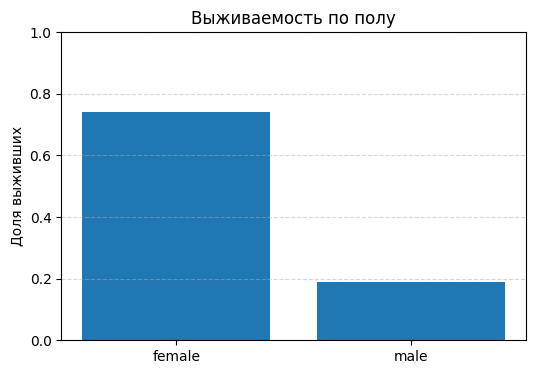

In [27]:
fig = plt.figure(figsize=(6,4))
x = np.arange(len(surv_by_sex))
plt.bar(x, surv_by_sex.values)
plt.xticks(x, surv_by_sex.index)
plt.ylim(0, 1)
plt.ylabel('Доля выживших')
plt.title('Выживаемость по полу')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

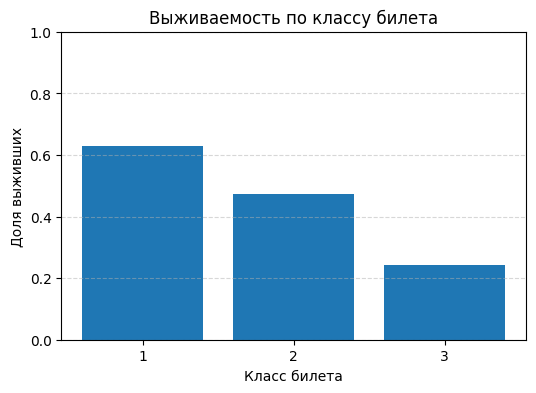

In [28]:
# доля выживших по классу (1, 2, 3)
surv_by_pclass = (train
                  .groupby('Pclass')['Survived']
                  .mean()
                  .sort_index())

fig = plt.figure(figsize=(6,4))
x = np.arange(len(surv_by_pclass))
plt.bar(x, surv_by_pclass.values)
plt.xticks(x, surv_by_pclass.index.astype(str))
plt.ylim(0, 1)
plt.ylabel('Доля выживших')
plt.xlabel('Класс билета')
plt.title('Выживаемость по классу билета')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

/tmp/ipython-input-2103370699.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age['age_bin'] = pd.cut(age['Age'], bins=bins, right=False)
/tmp/ipython-input-2103370699.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('age_bin')['Survived']


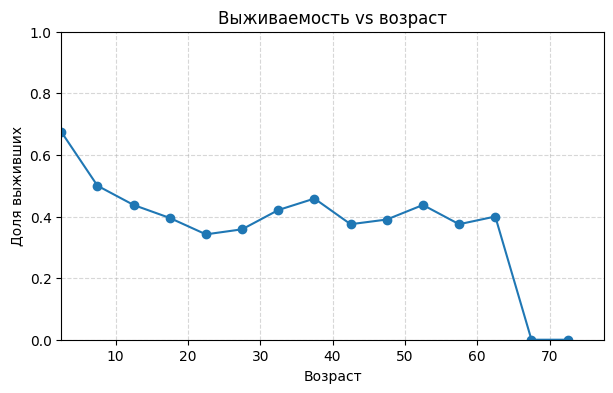

In [32]:
# бинируем возраст и считаем долю выживших в каждом бине
#    Это важно, потому что нам нужны одновременно и возраст, и метка выживания.
age = train[['Age','Survived']]
#    np.arange(0, 85, 5) создаст массив [0, 5, 10, ..., 80].
bins = np.arange(0, 85, 5)  # шаг 5 лет
#    pd.cut раскладывает числовой признак по «коробкам».
#    - bins=bins — используем заданные нами границы
#    - right=False — делаем полуинтервалы вида [a, b), т.е. правая граница НЕ включается
#      (это убирает двусмысленность на стыках и делает бины одинаковыми по смыслу).
age['age_bin'] = pd.cut(age['Age'], bins=bins, right=False)
# Для каждого бина считаем среднее значение целевой переменной Survived.
rate_by_agebin = (age
                  .groupby('age_bin')['Survived']
                  .mean())
#    Интуитивно хотим поставить точку в "середину" каждого возрастного интервала
centers = [interval.left + (interval.length/2) for interval in rate_by_agebin.index]


# Строим график.
fig = plt.figure(figsize=(7,4))
plt.plot(centers, rate_by_agebin.values, marker='o')
plt.ylim(0, 1)
plt.xlim(min(centers), max(centers))
plt.xlabel('Возраст')
plt.ylabel('Доля выживших')
plt.title('Выживаемость vs возраст')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## Фичи для Titanic: что это, зачем и как считаются

### 1) `FamilySize`
- **Как считаем:** `FamilySize = SibSp + Parch + 1` (прибавляем самого пассажира).
- **Зачем:** отражает, путешествует ли человек один, в маленькой/большой семье.
- **Смысл:** одиночкам сложнее спастись, очень большим группам — тоже; средний размер часто “лучше”.
- **Для модели:** числовой признак, хорошо ловит зависимость выживаемости от окружения.


In [62]:
full['FamilySize'] = full['SibSp'] + full['Parch'] + 1

### 2) `IsAlone`
- **Как считаем:** `IsAlone = int(FamilySize == 1)`.
- **Зачем:** бинарный индикатор одиночки.
- **Смысл:** одиночки выживали реже.
- **Для модели:** простой и информативный бинарный флаг, часто полезнее, чем сырой `SibSp`/`Parch`.

In [63]:
full['IsAlone'] = (full['FamilySize'] == 1).astype(int)


### 3) `Title` (титул из `Name`)
- **Как считаем:** регулярным выражением берём подстроку между запятой и точкой в `Name`
  (например, из `"Braund, Mr. Owen Harris"` → `"Mr"`), редкие титулы сводим в `"Rare"`.
- **Зачем:** для пола/возраста/социального статуса.
- **Смысл:** `Mrs/Miss/Master` коррелируют с выживаемостью.
- **Для модели:** категориальный, даёт хороший прирост качества.

In [64]:
import re

In [65]:
title_series = (
    full['Name'] # берём столбец Name
      .str.extract(r',\s*([^\.]+)\.', expand=False) # применяет регулярное выражение ко всем строкам столбца;
                                                    # expand=False → вернуть Series (а не DataFrame)
      .str.strip() # Избавимся от лишних пробелов
)

#### Разбор регулярного выражения `r',\s*([^\.]+)\.'`


Эта регулярка извлекает титул из строки `Name` в датасете Titanic.  
Вот что делает каждая её часть:

---

| Элемент | Расшифровка | Что делает |
|----------|--------------|-------------|
| **`r''`** | «Raw string» — сырой литерал Python | Отключает экранирование в строке: `\` остаются как есть для регулярки |
| **`,`** | Буквальная запятая | В именах Titanic после фамилии идёт запятая: `"Braund, Mr. Owen Harris"` |
| **`\s*`** | Любые пробельные символы (пробел, таб и т.д.), 0 или больше | Позволяет пропустить пробелы после запятой |
| **`(` … `)`** | Захватывающая группа | То, что найдено внутри скобок, вернётся функцией `.str.extract()` |
| **`[^\.]+`** | Символьный класс отрицания | Берём 1+ символов, **не являющихся точкой** — фактически «всё до первой точки» |
| **`\.`** | Буквальная точка | Точка, завершающая титул (`Mr.` / `Mrs.` / `Dr.` и т.п.) |

---

#### Итоговая логика
> «Найди запятую, пропусти пробелы, возьми всё до ближайшей точки — это титул.»

---


#### Пример

| Исходная строка `Name` | Совпадение `([^\.]+)` |
|--------------------------|-----------------------|
| `Braund, Mr. Owen Harris` | `Mr` |
| `Cumings, Mrs. John Bradley (Florence Briggs Thayer)` | `Mrs` |

In [66]:
common_titles = {'Mr', 'Mrs', 'Miss', 'Master'}
title_series = title_series.where(title_series.isin(common_titles), 'Rare')
full['Title'] = title_series.fillna('Unknown')# на всякий случай подстрахуемся от NaN


### 4) `HasCabin`
- **Как считаем:** `HasCabin = int(Cabin не NaN)`.
- **Зачем:** факт наличия каюты — символ высокого класса/палубы.
- **Смысл:** у 1-го класса чаще есть каюта → ближе к шлюпкам.
- **Для модели:** бинарный флаг из “пропуска” часто информативен.

In [56]:
full['HasCabin'] = full['Cabin'].notna().astype(int)

KeyError: 'Cabin'

### Визуализация пользы новых фич

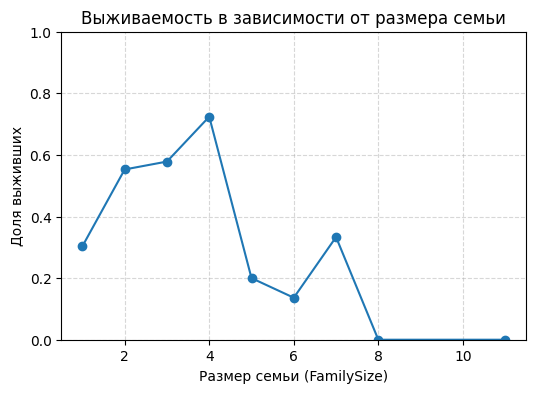

In [67]:
# Группируем и считаем долю выживших
family_surv = (full.groupby('FamilySize')['Survived']
                   .mean()
                   .sort_index())

fig = plt.figure(figsize=(6,4))
plt.plot(family_surv.index, family_surv.values, marker='o')
plt.xlabel('Размер семьи (FamilySize)')
plt.ylabel('Доля выживших')
plt.title('Выживаемость в зависимости от размера семьи')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0,1)
plt.show()

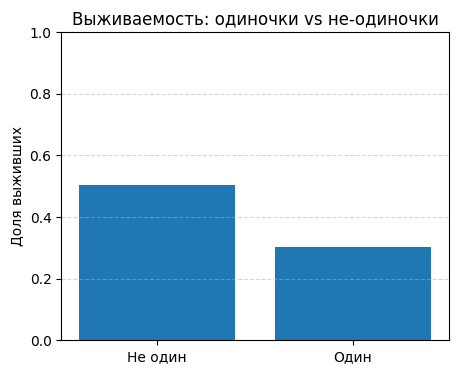

In [69]:
# Доля выживших для двух категорий IsAlone = {0,1}
alone_surv = full.groupby('IsAlone')['Survived'].mean()

fig = plt.figure(figsize=(5,4))
plt.bar(['Не один', 'Один'], alone_surv.values)
plt.ylim(0,1)
plt.ylabel('Доля выживших')
plt.title('Выживаемость: одиночки vs не-одиночки')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


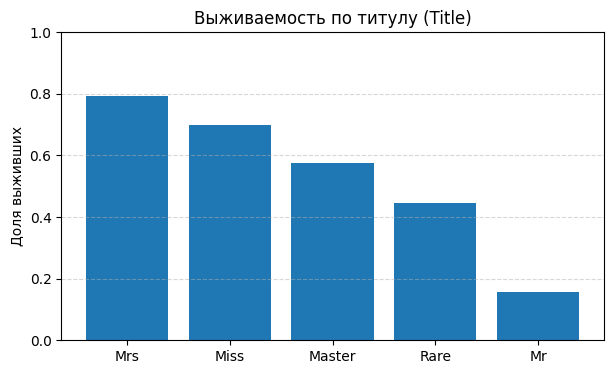

In [70]:
# Средняя выживаемость по титулу
title_surv = full.groupby('Title')['Survived'].mean().sort_values(ascending=False)

fig = plt.figure(figsize=(7,4))
plt.bar(title_surv.index, title_surv.values)
plt.ylim(0,1)
plt.ylabel('Доля выживших')
plt.title('Выживаемость по титулу (Title)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

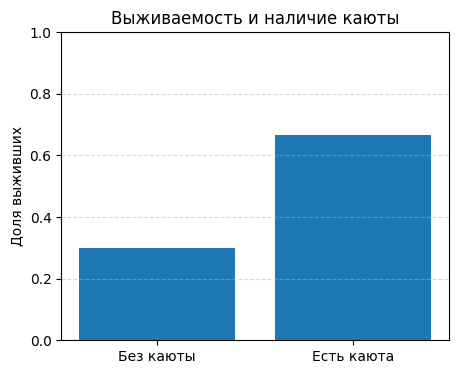

In [71]:
# Группируем по HasCabin и считаем долю выживших
cabin_surv = full.groupby('HasCabin')['Survived'].mean()

fig = plt.figure(figsize=(5,4))
plt.bar(['Без каюты','Есть каюта'], cabin_surv.values)
plt.ylim(0,1)
plt.ylabel('Доля выживших')
plt.title('Выживаемость и наличие каюты')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Выводы

- Новые признаки действительно несут информацию о шансах на выживание.  
- `IsAlone` и `FamilySize` показывают социальный фактор.  
- `Title` и `HasCabin` отражают статус и условия размещения.  
- Всё это даёт модели дополнительные осмысленные признаки, которые она может использовать при обучении.

## Корреляции между признаками и целевой переменной (`Survived`)

Чтобы понять, какие фичи сильнее всего связаны с выживаемостью, построим **тепловую карту (heatmap)**.
Корреляция показывает степень линейной зависимости между переменными (от -1 до 1):
- **близко к +1** → прямая связь (чем больше одно, тем больше другое);  
- **близко к -1** → обратная связь (чем больше одно, тем меньше другое);  
- **около 0** → линейной зависимости почти нет.


In [72]:
data_corr = full.copy()

In [73]:
# Кодируем категориальные признаки в числа
# (чтобы можно было считать корреляции)
cat_cols = data_corr.select_dtypes('object').columns.tolist()
for col in cat_cols:
    data_corr[col] = data_corr[col].astype('category').cat.codes

In [76]:
# На всякий случай уберём ID и неинформативные поля
for drop_col in ['PassengerId', 'Name', 'Ticket']:
    if drop_col in data_corr.columns:
        data_corr = data_corr.drop(columns=[drop_col])

In [77]:
# Считаем матрицу корреляций (по числовым колонкам)
corr_matrix = data_corr.corr(numeric_only=True)

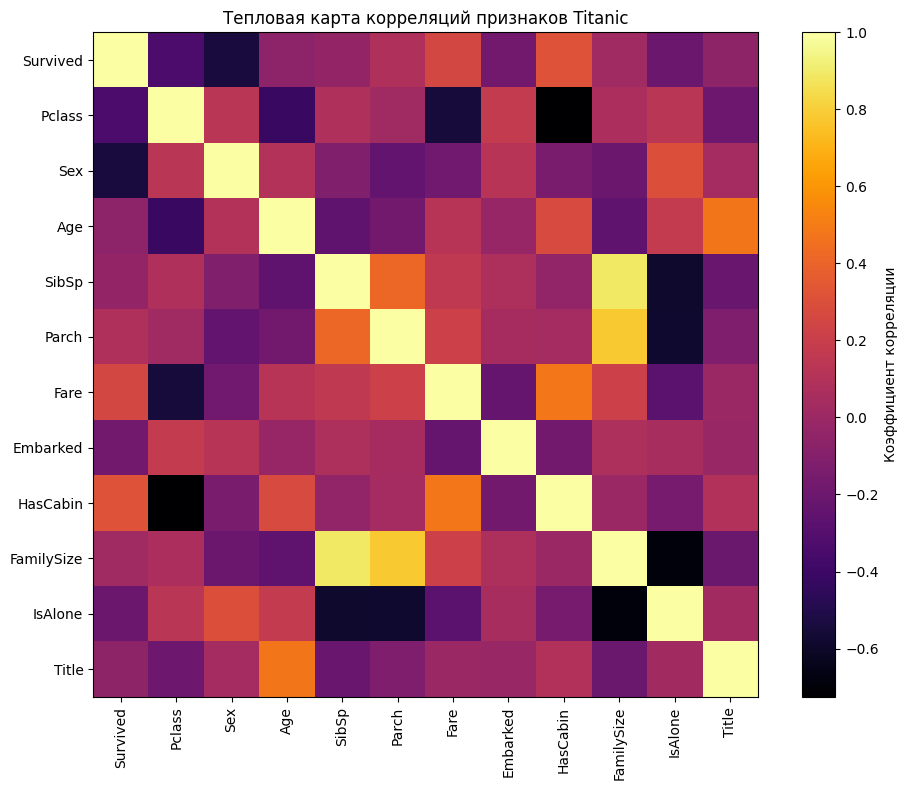

In [78]:
# Строим heatmap
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='inferno', interpolation='nearest')
plt.colorbar(label='Коэффициент корреляции')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Тепловая карта корреляций признаков Titanic')
plt.tight_layout()
plt.show()

### Интерпретация

- **`Sex` (в кодированной форме)** и `Pclass` дают сильную отрицательную корреляцию с `Survived` —  
  мужчины и пассажиры 3-го класса выживали реже.  
- **`Fare`**, **`Title`**, **`HasCabin`**, **`FamilySize`** — положительная связь:  
  чем выше значение этих признаков, тем больше шанс выжить.  
- **`IsAlone`** — отрицательная корреляция: одиночки выживали хуже.  
- Корреляции между признаками (например, `Pclass` ↔ `Fare`) показывают,
  что некоторые фичи частично дублируют друг друга — это нормально.

> Корреляция не означает причинность!  
> Модель машинного обучения учитывает нелинейные зависимости, поэтому слабая корреляция ≠ бесполезный признак.


## Этап обучения: делим данные и обучаем модель Random Forest


Мы уже очистили и подготовили данные — теперь построим простую модель,
которая будет предсказывать, выжил ли пассажир (`Survived`).

В качестве алгоритма возьмём **RandomForestClassifier** —
ансамбль решающих деревьев, который хорошо работает «из коробки» и не чувствителен к масштабу признаков.

Импорты

In [98]:
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, ConfusionMatrixDisplay,
                             RocCurveDisplay)


Разделим данные на обучающую и тестовую выборки

In [80]:
# Целевая переменная и признаки
target = 'Survived'
X = full.drop(columns=[target])
y = full[target]

# Делим на train/valid (80/20), стратификация сохраняет баланс классов
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [81]:
print("Размер обучающей выборки:", X_train.shape)
print("Размер валидационной выборки:", X_valid.shape)

Размер обучающей выборки: (712, 14)
Размер валидационной выборки: (179, 14)


Готовим препроцессор для числовых и категориальных признаков

In [91]:
# Определим типы признаков
num_features = ['Age','SibSp','Parch','Fare','FamilySize','IsAlone','Pclass']
cat_features = ['Sex','Embarked','Title','HasCabin']

In [92]:
# Препроцессинг для числовых: медиана вместо NaN
numeric_prep = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Для категориальных: наиболее частое значение + OneHotEncoder
categorical_prep = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Объединяем в единый препроцессор
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_prep, num_features),
        ('cat', categorical_prep, cat_features)
    ],
    remainder='drop' # прочие колонки - дроп
)

Собираем Pipeline: препроцессор + модель RandomForest

In [93]:
# Создаём модель с базовыми параметрами
rf_model = RandomForestClassifier(
    n_estimators=200,     # количество деревьев
    max_depth=None,       # глубина не ограничена
    random_state=42,
    n_jobs=-1             # использовать все ядра
)

In [94]:
# Склеиваем всё в единый Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocess),
    ('model', rf_model)
])

In [96]:
# Обучаем модель
rf_pipeline.fit(X_train, y_train)
print("Модель обучена")

Модель обучена


Оцениваем качество модели

In [99]:
y_pred = rf_pipeline.predict(X_valid)
y_proba = rf_pipeline.predict_proba(X_valid)[:, 1]

In [100]:
acc  = accuracy_score(y_valid, y_pred)
prec = precision_score(y_valid, y_pred)
rec  = recall_score(y_valid, y_pred)
f1   = f1_score(y_valid, y_pred)
roc  = roc_auc_score(y_valid, y_proba)

In [107]:
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {roc:.3f}")

Accuracy : 0.799
Precision: 0.739
Recall   : 0.739
F1-score : 0.739
ROC AUC  : 0.827


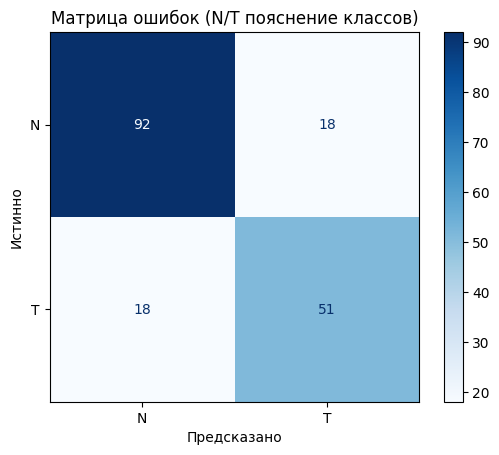

In [111]:
# Матрица ошибок
ConfusionMatrixDisplay.from_estimator(
    rf_pipeline, X_valid, y_valid,
    display_labels=['N','T'],     # подписи вместо 0/1
    cmap='Blues'                  # мягкая палитра
)
plt.title('Матрица ошибок (N/T пояснение классов)')
plt.xlabel('Предсказано')
plt.ylabel('Истинно')
plt.show()

На графике выше показана **Confusion Matrix** — таблица, которая иллюстрирует,
как модель классифицирует два возможных исхода:

- **T (True / 1)** — пассажир **выжил**  
- **N (Negative / 0)** — пассажир **не выжил**

Как читать таблицу

| Истинно ↓ / Предсказано → | **N (не выжил)** | **T (выжил)** |
|----------------------------|------------------|----------------|
| **N (не выжил)** | **92 — TN (True Negative)**<br>Модель верно предсказала, что человек не выжил. | **18 — FP (False Positive)**<br>Ошибочно решила, что человек выжил, хотя он погиб. |
| **T (выжил)** | **18 — FN (False Negative)**<br>Ошибочно решила, что человек не выжил, хотя он выжил. | **51 — TP (True Positive)**<br>Модель верно определила выжившего. |


## Интерпретация метрик качества модели

После обучения модели мы вывели:



### 1. **Accuracy** — общая точность классификации  

**Формула:**  
$$
\text{Accuracy}=\frac{TP+TN}{TP+TN+FP+FN}
$$

In [102]:
print(f"Accuracy : {acc:.3f}")

Accuracy : 0.799



**Смысл:** доля всех правильно классифицированных пассажиров.  
**Интерпретация:**  
модель правильно определяет исход для ~80 % людей (8 из 10 случаев).

**Когда полезно:** если классы примерно сбалансированы и обе ошибки одинаково «дороги».  
**Когда врет:** если один класс сильно преобладает (например, 80 % погибших).

### 2. **Precision** — точность положительного класса (1 = «выжил»)  
**Формула:**  
$$
\text{Precision}=\frac{TP}{TP+FP}
$$

**Смысл:** из всех, кого модель «спасла», сколько реально выжили.  
**Интерпретация:** 0.739 → из всех «предсказанных выживших» реально выжили 74 %.  
**Ошибка:** оставшиеся 26 % — ложные срабатывания (ошибочно спасённые).

**Когда важно:** когда критично **не ошибаться с положительными**  
(например, предсказание болезни — ложная тревога хуже пропуска).


In [103]:
print(f"Precision: {prec:.3f}")

Precision: 0.739



---

### 3. **Recall** — полнота (чувствительность)  
**Формула:**  
$$
\text{Recall}=\frac{TP}{TP+FN}
$$

**Смысл:** из всех реально выживших, сколько модель нашла.  
**Интерпретация:** 0.739 → модель правильно находит ~74 % выживших.  
**Ошибка:** около 26 % реальных выживших «потерялись».

**Когда важно:** когда нужно **не пропустить положительный случай**  
(например, при мед-скрининге или сигнализации аварий).

---

In [104]:
print(f"Recall   : {rec:.3f}")

Recall   : 0.739



### ⚙️ 4. **F1-score** — баланс между Precision и Recall  
**Формула:**  
$$
F1=2\cdot\frac{\text{Precision}\cdot \text{Recall}}{\text{Precision}+\text{Recall}}
$$

**Смысл:** гармоническое среднее точности и полноты.  
**Интерпретация:** 0.739 → модель держит неплохой баланс между «не ошибиться» и «ничего не упустить».  
**Замечание:** если Precision ≫ Recall — модель слишком осторожна; если наоборот — слишком рискованна.

---

In [105]:
print(f"F1-score : {f1:.3f}")

F1-score : 0.739



### 5. **ROC AUC** — площадь под ROC-кривой  
**Смысл:** показывает, насколько хорошо модель различает классы  
при всех возможных порогах вероятности.

**Интерпретация:** 0.827 → модель хорошо отделяет выживших от погибших.  
(0.5 — случайное угадывание, 0.7–0.8 — нормально, 0.8–0.9 — хорошо, > 0.9 — отлично.)

---

In [106]:
print(f"ROC AUC  : {roc:.3f}")

ROC AUC  : 0.827


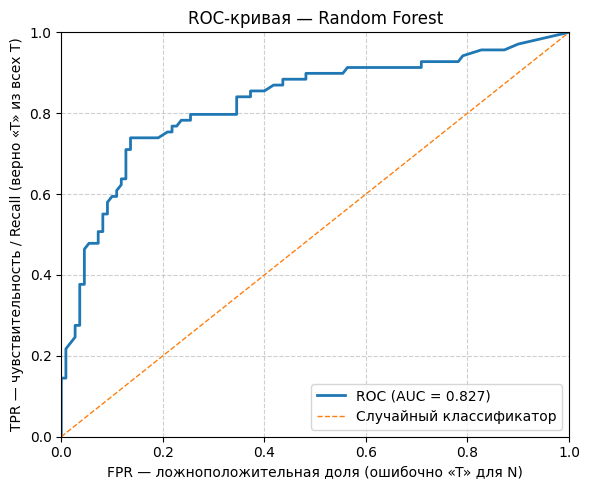

In [117]:
# Вероятности положительного класса (T = выжил)
y_score = rf_pipeline.predict_proba(X_valid)[:, 1]

# Точки ROC-кривой и AUC
fpr, tpr, thr = roc_curve(y_valid, y_score)   # FPR=ложноположительная доля, TPR=чувствительность (Recall)
roc_auc = auc(fpr, tpr)

# Рисуем
fig = plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, label='Случайный классификатор')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('FPR — ложноположительная доля (ошибочно «T» для N)')
plt.ylabel('TPR — чувствительность / Recall (верно «T» из всех T)')
plt.title('ROC-кривая — Random Forest')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



### Итог по результатам модели

| Метрика | Значение | Интерпретация |
|----------|-----------|---------------|
| Accuracy | **0.799** | Хорошая общая точность (≈ 8 из 10 предсказаний верны) |
| Precision | **0.739** | 74 % предсказанных выживших действительно выжили |
| Recall | **0.739** | Модель нашла 74 % всех реальных выживших |
| F1-score | **0.739** | Баланс между precision и recall, без сильного перекоса |
| ROC AUC | **0.827** | Модель хорошо различает выживших и погибших |

**Вывод:**  
Модель Random Forest показывает стабильное и интерпретируемое качество:  
— предсказания точнее случайного в 1.5 – 1.6 раза;  
— ошибок обоих типов примерно поровну;  
— AUC > 0.8 означает, что модель уверенно различает классы.  